In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pystan

%matplotlib inline

In [44]:
gwp_code = """
data {
    int<lower=1> N;    //time steps
    int<lower=1> D;    //dimension
    int<lower=1> nu;   //degrees of freedom
    matrix[D,D] L;     //cholesky decomposition of V
    vector[D] dat[N];
    real t[N];
}
transformed data {
    vector[N] mu;
    for(n in 1:N) mu[n] = 0;
}
parameters {
    vector[N] Z[D, nu];
    real<lower=0> theta;     //kernel parameter for the gaussian process  
}
transformed parameters {
    matrix[D, D] S[N];
    matrix[D, nu] U[N];      //each U[N] is a gaussian process
    matrix[N, N] K;
    matrix[N, N] L_K;
    real log_lik = 0;
    
    K = cov_exp_quad(t, 1.0, theta);   //kernel function for U
                                        // diagonal will be overwritten
    for (i in 1:N)
        K[i,i] = 1.001;
    L_K = cholesky_decompose(K);
    
    for (d in 1:D){
        for (i in 1:nu){
            vector[N] tmp = L_K*Z[d,i];
            for (n in 1:N){
                U[n,d,i] = tmp[n];
            }
        }
    }

    for (n in 1:N){
        S[n] = tcrossprod(L*U[n]);
    }

    log_lik = log_lik - 0.5*N*log(2*3.14159265359);
    for (n in 1:N){
        log_lik = log_lik - 0.5*log_determinant(S[n]);
        log_lik = log_lik - 0.5*dat[n]'*inverse(S[n])*dat[n];
    }
}
model {
    theta ~ normal(0,5);    //prior on lengthscale
    
    //for (d in 1:D){
    //    for (i in 1:nu){
    //        U[,d,i] ~ multi_normal(mu, K);   //GP prior
    //    }
    //}
    for (d in 1:D){
        for (i in 1:nu){
            Z[d,i] ~ normal(0, 1);   //GP prior
        }
    }
    
    increment_log_prob(log_lik);
}
"""

stan_model = pystan.StanModel(model_code = gwp_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_405dff6684d8b014d051bf8e8ab3f307 NOW.


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: covariance is not positive-semidefinite.


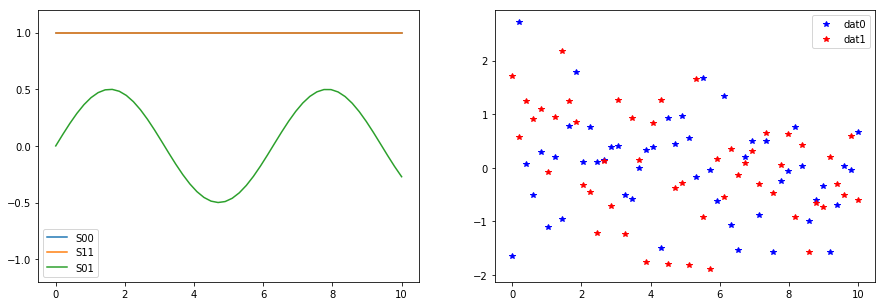

In [51]:
N = 50
D = 2
nu = 5

t_start = 0
t_end = 10
t = np.linspace(t_start, t_end, N)

V = np.array([ [1., 0.], [0., 1.] ])
L = np.linalg.cholesky(V)


S = np.array([ [[1., 0.5*np.sin(t_)], [0.2*np.sin(t_), 1.]] for t_ in t])

dat = np.array([ np.random.multivariate_normal(np.zeros(D), S_) for S_ in S ])

#plot data
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,2,1)
ax.plot(t, S[:,0,0], label="S00")
ax.plot(t, S[:,1,1], label="S11")
ax.plot(t, S[:,0,1], label="S01")
ax.legend()
ax.set_ylim([-1.2,1.2])

ax = fig.add_subplot(1,2,2)
ax.plot(t, dat[:,0], "b*", label="dat0")
ax.plot(t, dat[:,1], "r*", label="dat1")
ax.legend()

plt.show()

In [52]:
parameter_dict = {'N': N, 'D': D, 'nu': nu, 'L':L, 'dat':dat, 't':t}
fit = stan_model.sampling(data = parameter_dict)

In [53]:
fit.extract(['theta'])['theta'].mean()

8.115607970742861

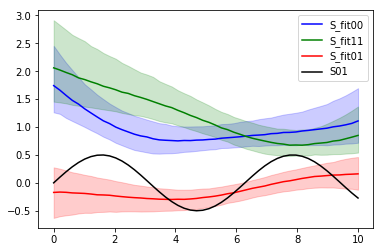

In [54]:
S_fit = fit.extract('S')['S']
S_fit_mean = S_fit.mean(axis=0)
S_fit_median = np.percentile(S_fit, 50, axis=0)
S_fit_top = np.percentile(S_fit, 80, axis=0)
S_fit_bot = np.percentile(S_fit, 20, axis=0)

fig = plt.figure()
plt.plot(t, S_fit_median[:,0,0], 'b', label="S_fit00")
plt.fill_between(t, S_fit_top[:,0,0], S_fit_bot[:,0,0], color='b',  alpha=0.2)
plt.plot(t, S_fit_median[:,1,1], 'g', label="S_fit11")
plt.fill_between(t, S_fit_top[:,1,1], S_fit_bot[:,1,1], color='g',  alpha=0.2)
plt.plot(t, S_fit_median[:,0,1], 'r', label="S_fit01")
plt.fill_between(t, S_fit_top[:,0,1], S_fit_bot[:,0,1], color='r',  alpha=0.2)
plt.plot(t, S[:,0,1], color='black', label="S01")
plt.legend()
plt.show()

In [49]:
fit

Inference for Stan model: anon_model_405dff6684d8b014d051bf8e8ab3f307.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[0,0,0]    -0.02    0.02   0.72  -1.25  -0.61  -0.03   0.57   1.24 2185.0    1.0
Z[1,0,0]     0.03    0.01   0.67  -1.15  -0.53   0.04   0.58   1.16 2151.0    1.0
Z[0,1,0]  -3.0e-4    0.02   0.71  -1.26  -0.57 5.4e-3   0.58   1.22 2138.0    1.0
Z[1,1,0]   6.7e-3    0.01   0.66  -1.13  -0.52-6.5e-3   0.54   1.19 2119.0    1.0
Z[0,2,0]     0.01    0.01   0.71  -1.25  -0.57 3.3e-3   0.58   1.26 2247.0    1.0
Z[1,2,0]     0.01    0.01   0.67  -1.16  -0.52   0.01   0.55   1.21 2229.0    1.0
Z[0,0,1]   6.0e-3    0.01   0.92  -1.83   -0.6 5.3e-3   0.62   1.84 4000.0    1.0
Z[1,0,1]    -0.01    0.02   0.96  -1.85  -0.67  -0.02   0.62   1.86 4000.0    1.0
Z[0,1,1]  -1.1e-3    0.02   0.95  -1.85  -0.63 6.2e-3   0.62    1.9 4000.

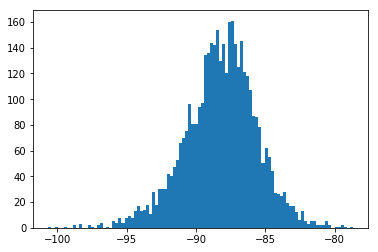

In [55]:
_ = plt.hist(fit.extract("log_lik")['log_lik'], bins=100)